In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import itertools

In [4]:
# Step 1: Create sample medical data
np.random.seed(42)
n_samples = 1000

print("Creating synthetic medical dataset...")

# Generate data with logical relationships
age = np.random.choice(['Young', 'Middle', 'Old'], n_samples, p=[0.3, 0.4, 0.3])
smoking = np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7])

# Exercise depends on age (younger people exercise more)
exercise_prob = {'Young': [0.7, 0.3], 'Middle': [0.5, 0.5], 'Old': [0.3, 0.7]}
exercise = []
for a in age:
    exercise.append(np.random.choice(['Yes', 'No'], p=exercise_prob[a]))

# Heart disease depends on age, smoking, and exercise
heart_disease = []
for i in range(n_samples):
    prob = 0.1  # Base probability
    
    if age[i] == 'Middle':
        prob += 0.2
    elif age[i] == 'Old':
        prob += 0.4
    
    if smoking[i] == 'Yes':
        prob += 0.3
    
    if exercise[i] == 'Yes':
        prob -= 0.2  # Exercise is protective
    
    prob = max(0, min(1, prob))
    heart_disease.append(np.random.choice(['Yes', 'No'], p=[prob, 1-prob]))

Creating synthetic medical dataset...


In [5]:
# Create DataFrame
data = pd.DataFrame({
    'Age': age,
    'Smoking': smoking,
    'Exercise': exercise,
    'Heart_Disease': heart_disease
})

print("Sample of the data:")
print(data.head(10))
print(f"\nDataset shape: {data.shape}")


Sample of the data:
      Age Smoking Exercise Heart_Disease
0  Middle     Yes      Yes            No
1     Old      No      Yes            No
2     Old      No       No           Yes
3  Middle      No      Yes            No
4   Young      No      Yes            No
5   Young      No       No            No
6   Young      No      Yes            No
7     Old      No       No           Yes
8  Middle     Yes      Yes            No
9     Old      No       No           Yes

Dataset shape: (1000, 4)


In [6]:
# Step 2: Define our simple PGM class
class SimplePGM:
    def __init__(self):
        self.edges = []
        self.nodes = set()
        self.conditional_probs = {}
        self.data = None
    
    def add_edge(self, parent, child):
        """Add a directed edge from parent to child"""
        self.edges.append((parent, child))
        self.nodes.add(parent)
        self.nodes.add(child)
    
    def fit(self, data):
        """Learn conditional probabilities from data"""
        self.data = data
        print("\nLearning conditional probabilities from data...")
        
        # For each node, calculate conditional probabilities
        for node in self.nodes:
            parents = [parent for parent, child in self.edges if child == node]
            
            if not parents:
                # No parents - just marginal probability
                prob_table = data[node].value_counts(normalize=True).to_dict()
                self.conditional_probs[node] = {'parents': [], 'table': prob_table}
                print(f"\nMarginal probabilities for {node}:")
                for value, prob in prob_table.items():
                    print(f"  P({node}={value}) = {prob:.3f}")
            else:
                # Has parents - conditional probability
                self.conditional_probs[node] = {'parents': parents, 'table': {}}
                
                print(f"\nConditional probabilities for {node} given {parents}:")
                
                # Group by parent values
                if len(parents) == 1:
                    parent_groups = data.groupby(parents[0])
                else:
                    parent_groups = data.groupby(parents)
                
                for parent_vals, group in parent_groups:
                    child_probs = group[node].value_counts(normalize=True).to_dict()
                    self.conditional_probs[node]['table'][parent_vals] = child_probs
                    
                    if len(parents) == 1:
                        print(f"  Given {parents[0]}={parent_vals}:")
                    else:
                        parent_str = ', '.join([f"{p}={v}" for p, v in zip(parents, parent_vals)])
                        print(f"  Given {parent_str}:")
                    
                    for child_val, prob in child_probs.items():
                        print(f"    P({node}={child_val}) = {prob:.3f}")
    
    def predict_probability(self, target_node, target_value, evidence=None):
        """Simple prediction using learned probabilities"""
        if evidence is None:
            evidence = {}
        
        # This is a simplified version - just looks up conditional probability
        if target_node not in self.conditional_probs:
            return None
        
        node_info = self.conditional_probs[target_node]
        parents = node_info['parents']
        
        if not parents:
            # No parents case
            return node_info['table'].get(target_value, 0)
        
        # Find matching parent configuration
        if len(parents) == 1:
            parent_val = evidence.get(parents[0])
            if parent_val in node_info['table']:
                return node_info['table'][parent_val].get(target_value, 0)
        else:
            parent_tuple = tuple(evidence.get(p) for p in parents)
            if parent_tuple in node_info['table']:
                return node_info['table'][parent_tuple].get(target_value, 0)
        
        return 0

In [7]:
# Step 3: Build the model
model = SimplePGM()

# Define network structure
model.add_edge('Age', 'Exercise')
model.add_edge('Age', 'Heart_Disease')
model.add_edge('Smoking', 'Heart_Disease')
model.add_edge('Exercise', 'Heart_Disease')

print("Network structure:")
print("Edges:", model.edges)

# Learn from data
model.fit(data)

Network structure:
Edges: [('Age', 'Exercise'), ('Age', 'Heart_Disease'), ('Smoking', 'Heart_Disease'), ('Exercise', 'Heart_Disease')]

Learning conditional probabilities from data...

Marginal probabilities for Age:
  P(Age=Middle) = 0.393
  P(Age=Young) = 0.319
  P(Age=Old) = 0.288

Conditional probabilities for Exercise given ['Age']:
  Given Age=Middle:
    P(Exercise=No) = 0.504
    P(Exercise=Yes) = 0.496
  Given Age=Old:
    P(Exercise=No) = 0.705
    P(Exercise=Yes) = 0.295
  Given Age=Young:
    P(Exercise=Yes) = 0.671
    P(Exercise=No) = 0.329

Conditional probabilities for Heart_Disease given ['Age', 'Smoking', 'Exercise']:
  Given Age=Middle, Smoking=No, Exercise=No:
    P(Heart_Disease=No) = 0.754
    P(Heart_Disease=Yes) = 0.246
  Given Age=Middle, Smoking=No, Exercise=Yes:
    P(Heart_Disease=No) = 0.910
    P(Heart_Disease=Yes) = 0.090
  Given Age=Middle, Smoking=Yes, Exercise=No:
    P(Heart_Disease=Yes) = 0.650
    P(Heart_Disease=No) = 0.350
  Given Age=Middle, Smok

C:\Users\turningpointKS\AppData\Local\Temp\ipykernel_6184\4171695620.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


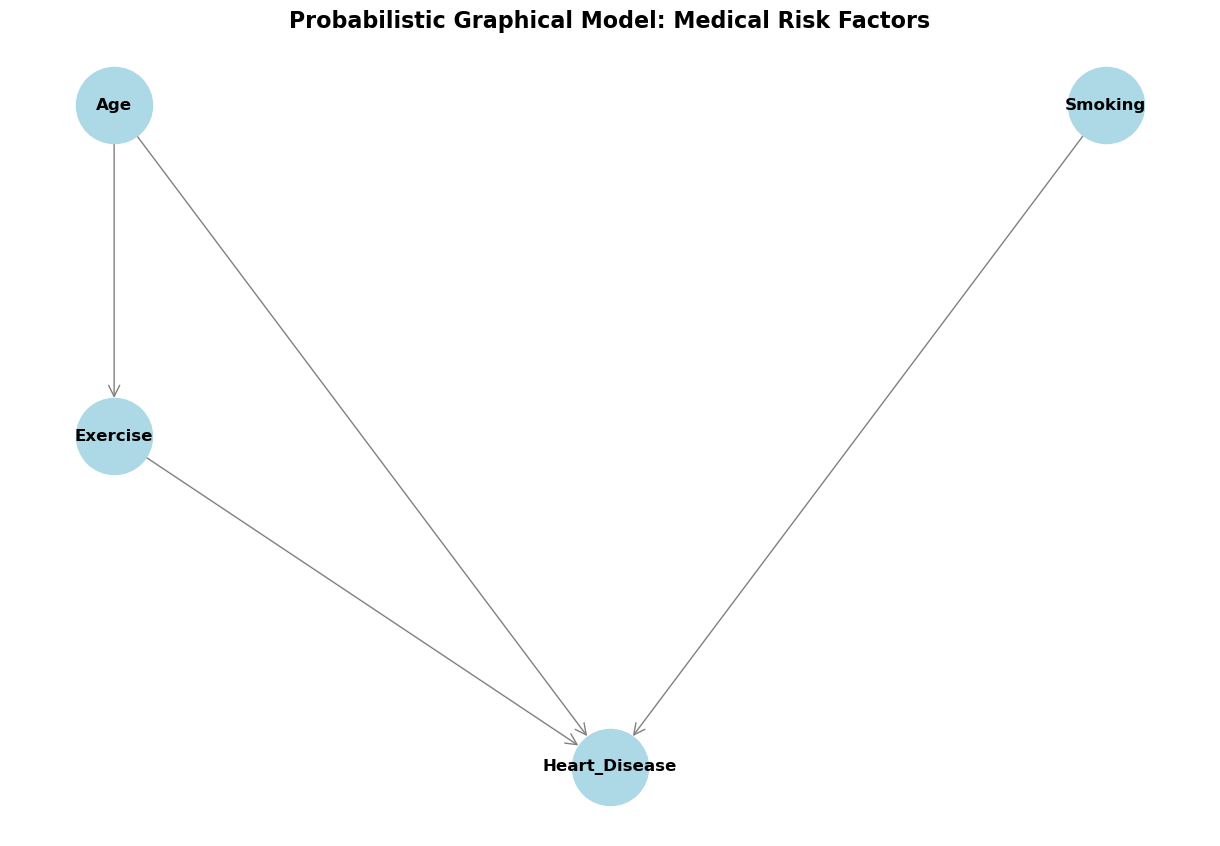

In [8]:
# Step 4: Visualize the graph
plt.figure(figsize=(12, 8))

# Create networkx graph
G = nx.DiGraph()
G.add_edges_from(model.edges)

# Define positions for better layout
pos = {
    'Age': (0, 1),
    'Smoking': (2, 1),
    'Exercise': (0, 0),
    'Heart_Disease': (1, -1)
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=12, font_weight='bold',
        arrows=True, arrowsize=20, edge_color='gray',
        arrowstyle='->')

plt.title("Probabilistic Graphical Model: Medical Risk Factors", 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
# Step 5: Make some predictions
print("\n" + "="*60)
print("MAKING PREDICTIONS:")
print("="*60)

# Example predictions
examples = [
    {'Age': 'Old', 'Smoking': 'Yes', 'Exercise': 'No'},
    {'Age': 'Young', 'Smoking': 'No', 'Exercise': 'Yes'},
    {'Age': 'Middle', 'Smoking': 'Yes', 'Exercise': 'Yes'}
]

for i, evidence in enumerate(examples, 1):
    prob_yes = model.predict_probability('Heart_Disease', 'Yes', evidence)
    prob_no = model.predict_probability('Heart_Disease', 'No', evidence)
    
    print(f"\nExample {i}: {evidence}")
    print(f"P(Heart_Disease=Yes) = {prob_yes:.3f}")
    print(f"P(Heart_Disease=No) = {prob_no:.3f}")



MAKING PREDICTIONS:

Example 1: {'Age': 'Old', 'Smoking': 'Yes', 'Exercise': 'No'}
P(Heart_Disease=Yes) = 0.818
P(Heart_Disease=No) = 0.182

Example 2: {'Age': 'Young', 'Smoking': 'No', 'Exercise': 'Yes'}
P(Heart_Disease=Yes) = 0.000
P(Heart_Disease=No) = 1.000

Example 3: {'Age': 'Middle', 'Smoking': 'Yes', 'Exercise': 'Yes'}
P(Heart_Disease=Yes) = 0.468
P(Heart_Disease=No) = 0.532


In [10]:
# Step 6: Validate with raw data statistics
print("\n" + "="*60)
print("VALIDATION - Raw data patterns:")
print("="*60)

print("\nHeart Disease rates by Age:")
age_stats = data.groupby('Age')['Heart_Disease'].value_counts(normalize=True).unstack()
print(age_stats.round(3))

print("\nHeart Disease rates by Smoking:")
smoking_stats = data.groupby('Smoking')['Heart_Disease'].value_counts(normalize=True).unstack()
print(smoking_stats.round(3))

print("\nHeart Disease rates by Exercise:")
exercise_stats = data.groupby('Exercise')['Heart_Disease'].value_counts(normalize=True).unstack()
print(exercise_stats.round(3))

print(f"\nOverall Heart Disease rate:")
overall = data['Heart_Disease'].value_counts(normalize=True)
print(overall.round(3))

print("\n" + "="*60)
print("What this PGM shows:")
print("- Statistical relationships between variables")
print("- How knowing one variable changes probabilities of others") 
print("- NOT necessarily causation, but correlation patterns")
print("- The graph structure represents our assumptions about dependencies")
print("="*60)


VALIDATION - Raw data patterns:

Heart Disease rates by Age:
Heart_Disease     No    Yes
Age                        
Middle         0.710  0.290
Old            0.444  0.556
Young          0.897  0.103

Heart Disease rates by Smoking:
Heart_Disease     No    Yes
Smoking                    
No             0.778  0.222
Yes            0.490  0.510

Heart Disease rates by Exercise:
Heart_Disease     No    Yes
Exercise                   
No             0.561  0.439
Yes            0.828  0.172

Overall Heart Disease rate:
Heart_Disease
No     0.693
Yes    0.307
Name: proportion, dtype: float64

What this PGM shows:
- Statistical relationships between variables
- How knowing one variable changes probabilities of others
- NOT necessarily causation, but correlation patterns
- The graph structure represents our assumptions about dependencies
